1. Preparação e processamento da base de dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Configurações para melhor visualização
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

2. Importação dos dados

In [ ]:
# Carregar os datasets
df_stocks = pd.read_excel('/content/stock_prices.xlsx')
df_companies = pd.read_csv('/content/companies.csv')

# Exibir as primeiras linhas para verificar
print("df_companies head:")
print(df_companies.head())
print("\ndf_stock_prices head:")
print(df_stocks.head())

df_companies head:
  stock_symbol              company
0         AAPL           Apple Inc.
1         ADBE           Adobe Inc.
2         AMZN     Amazon.com, Inc.
3          CRM     Salesforce, Inc.
4         CSCO  Cisco Systems, Inc.

df_stock_prices head:
  stock_symbol       date      open      high       low     close  adj_close  \
0         AAPL 2010-01-04  7.622500  7.660714  7.585000  7.643214   6.515213   
1         AAPL 2010-01-05  7.664286  7.699643  7.616071  7.656429   6.526476   
2         AAPL 2010-01-06  7.656429  7.686786  7.526786  7.534643   6.422664   
3         AAPL 2010-01-07  7.562500  7.571429  7.466071  7.520714   6.410790   
4         AAPL 2010-01-08  7.510714  7.571429  7.466429  7.570714   6.453412   

        volume  
0  493729600.0  
1  601904800.0  
2  552160000.0  
3  477131200.0  
4  447610800.0  


In [ ]:
# Resumo estatístico das variáveis numéricas
df_stocks.describe()

,date,open,high,low,close,adj_close,volume
count,45089,45089.000000,45089.000000,45089.000000,45089.000000,45089.000000,4.508900e+04
mean,2016-08-03 16:49:50.565326336,89.267274,90.370562,88.112582,89.272028,85.210443,5.298188e+07
min,2010-01-04 00:00:00,1.076000,1.108667,0.998667,1.053333,1.053333,5.892000e+05
25%,2013-05-30 00:00:00,25.670000,25.930180,25.360001,25.660000,22.077059,9.629500e+06
50%,2016-08-09 00:00:00,47.930000,48.459999,47.470001,47.970001,45.378979,2.646420e+07
75%,2019-10-22 00:00:00,128.660004,129.847031,127.250000,128.639999,113.679848,5.840030e+07
max,2023-01-24 00:00:00,696.280029,700.989990,686.090027,691.690002,691.690002,1.880998e+09
std,NaN,101.625934,103.000049,100.123385,101.591905,100.994995,9.324966e+07


3. Tratamento e preparação dos dados

3.1 Nulos

In [ ]:
# Verificar valores nulos
nulos_stocks = df_stocks.isnull().sum()
nulos_stocks = nulos_stocks[nulos_stocks > 0]

nulos_companies = df_companies.isnull().sum()
nulos_companies = nulos_companies[nulos_companies > 0]

# Exibir os resultados
print("Valores nulos em 'stock_prices.xlsx':")
print(nulos_stocks if not nulos_stocks.empty else "Nenhum valor nulo encontrado.")

print("\nValores nulos em 'companies.csv':")
print(nulos_companies if not nulos_companies.empty else "Nenhum valor nulo encontrado.")

Valores nulos em 'stock_prices.xlsx':
date         1
open         1
high         1
low          1
close        1
adj_close    1
volume       1
dtype: int64

Valores nulos em 'companies.csv':
Nenhum valor nulo encontrado.


In [ ]:
#Remoção da linha completa de valores nulos
df_stocks.dropna(inplace=True)

In [ ]:
# Tamanho do dataset
print(f"Número de linhas: {df_stocks.shape[0]}")
print(f"Número de colunas: {df_stocks.shape[1]}")

# Informações gerais sobre o DataFrame
df_stocks.info()
df_stocks.nunique()

Número de linhas: 45089
Número de colunas: 8
<class 'pandas.core.frame.DataFrame'>
Index: 45089 entries, 0 to 45088
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   stock_symbol  45089 non-null  object        
 1   date          45089 non-null  datetime64[ns]
 2   open          45089 non-null  float64       
 3   high          45089 non-null  float64       
 4   low           45089 non-null  float64       
 5   close         45089 non-null  float64       
 6   adj_close     45089 non-null  float64       
 7   volume        45089 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 3.1+ MB


,0
stock_symbol,14
date,3287
open,29798
high,30056
low,30028
close,30965
adj_close,41279
volume,43550


3.2 Duplicadas

In [ ]:
# Verificar todas as linhas duplicadas (originais + cópias)
duplicatas = df_stocks[df_stocks.duplicated(keep=False)]

# Exibir resultado
if not duplicatas.empty:
    print(f"Total de linhas duplicadas (incluindo originais): {duplicatas.shape[0]}")
    display(duplicatas)
else:
    print("Não há linhas duplicadas no dataset.")

Total de linhas duplicadas (incluindo originais): 2


,stock_symbol,date,open,high,low,close,adj_close,volume
45087,TSLA,2022-12-29,120.389999,123.57,117.5,121.82,121.82,221923300.0
45088,TSLA,2022-12-29,120.389999,123.57,117.5,121.82,121.82,221923300.0


In [ ]:
# Remover duplicatas com base nas colunas-chave 'stock_symbol' e 'date'
df_stocks = df_stocks.drop_duplicates(subset=['stock_symbol', 'date'], keep='first')

# Verificar o resultado
print(f"Número de registros após remoção de duplicatas: {df_stocks.shape[0]}")

Número de registros após remoção de duplicatas: 45088


3.3 Dados fora do escopo

In [ ]:
# Converter a coluna de data para datetime
df_stocks['date'] = pd.to_datetime(df_stocks['date'], errors='coerce')

# Verificar valores nulos
print("Datas nulas após conversão:", df_stocks['date'].isna().sum())

# Verificar o intervalo de datas
print("Menor data:", df_stocks['date'].min())
print("Maior data:", df_stocks['date'].max())


Datas nulas após conversão: 0
Menor data: 2010-01-04 00:00:00
Maior data: 2023-01-24 00:00:00


In [ ]:
# Garantindo que estamos usando apenas datas válidas e dentro do escopo
inicio = pd.to_datetime('2010-01-01')
fim = pd.to_datetime('2023-12-31')

3.4 Variáveis categóricas

In [ ]:
# Seleciona apenas colunas categóricas
cat_cols = df_stocks.select_dtypes(include='object').columns
print("Variáveis categóricas:", cat_cols)


Variáveis categóricas: Index(['stock_symbol'], dtype='object')


In [ ]:
# Verificando valores únicos de cada coluna categórica
for col in cat_cols:
    print(f"\n{col} - Valores únicos:")
    print(df_stocks[col].value_counts(dropna=False))

# Função para limpeza rápida
def limpar_categoria(coluna):
    return coluna.str.strip().str.lower().replace({
        'n/a': 'indefinido',
        'sem dados': 'indefinido',
        '': 'indefinido'
    })

# Aplicando a limpeza em todas as colunas categóricas
for col in cat_cols:
    df_stocks[col] = limpar_categoria(df_stocks[col])

# Padronizar stock_symbol
df_stocks['stock_symbol'] = df_stocks['stock_symbol'].str.strip().str.upper()
df_companies['stock_symbol'] = df_companies['stock_symbol'].str.strip().str.upper()


stock_symbol - Valores únicos:
stock_symbol
AAPL     3271
ADBE     3271
AMZN     3271
CRM      3271
CSCO     3271
GOOGL    3271
IBM      3271
INTC     3271
MSFT     3271
NFLX     3271
ORCL     3271
NVDA     3271
TSLA     3148
META     2688
Name: count, dtype: int64


3.5 Merge

In [ ]:
# Merge
df_merged = pd.merge(df_stocks, df_companies, on='stock_symbol', how='left')


In [ ]:
# Tamanho do dataset
print(f"Número de linhas: {df_merged.shape[0]}")
print(f"Número de colunas: {df_merged.shape[1]}")

# Informações gerais sobre o DataFrame
df_merged.info()

# Número de valores únicos por coluna
print(df_merged.nunique())

Número de linhas: 45088
Número de colunas: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45088 entries, 0 to 45087
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   stock_symbol  45088 non-null  object        
 1   date          45088 non-null  datetime64[ns]
 2   open          45088 non-null  float64       
 3   high          45088 non-null  float64       
 4   low           45088 non-null  float64       
 5   close         45088 non-null  float64       
 6   adj_close     45088 non-null  float64       
 7   volume        45088 non-null  float64       
 8   company       45088 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 3.1+ MB
stock_symbol       14
date             3287
open            29798
high            30056
low             30028
close           30965
adj_close       41279
volume          43550
company            14
dtype: int64


3.6 Tratamento outliers (IQR)

In [ ]:
# Calcular IQR para identificar outliers
Q1 = df_merged['volume'].quantile(0.25)
Q3 = df_merged['volume'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1 = df_merged['open'].quantile(0.25)
Q3 = df_merged['open'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1 = df_merged['high'].quantile(0.25)
Q3 = df_merged['high'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1 = df_merged['low'].quantile(0.25)
Q3 = df_merged['low'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1 = df_merged['adj_close'].quantile(0.25)
Q3 = df_merged['adj_close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

Q1 = df_merged['close'].quantile(0.25)
Q3 = df_merged['close'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

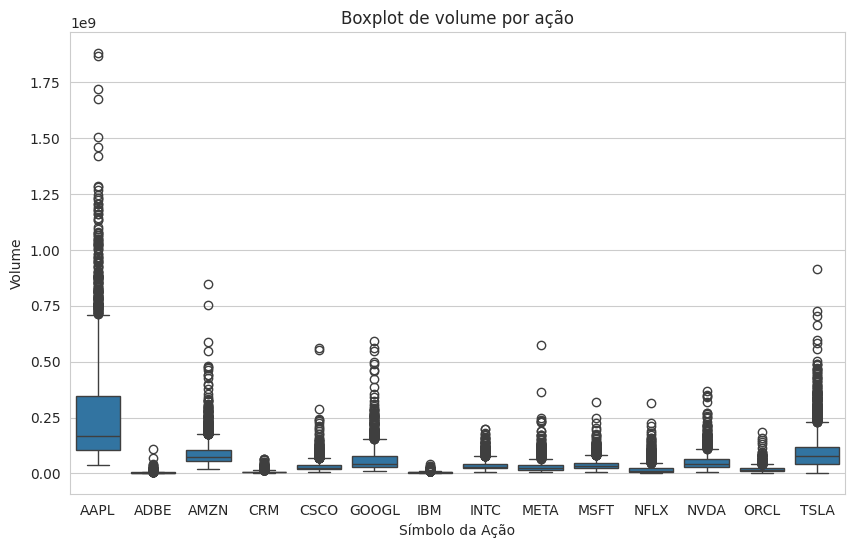

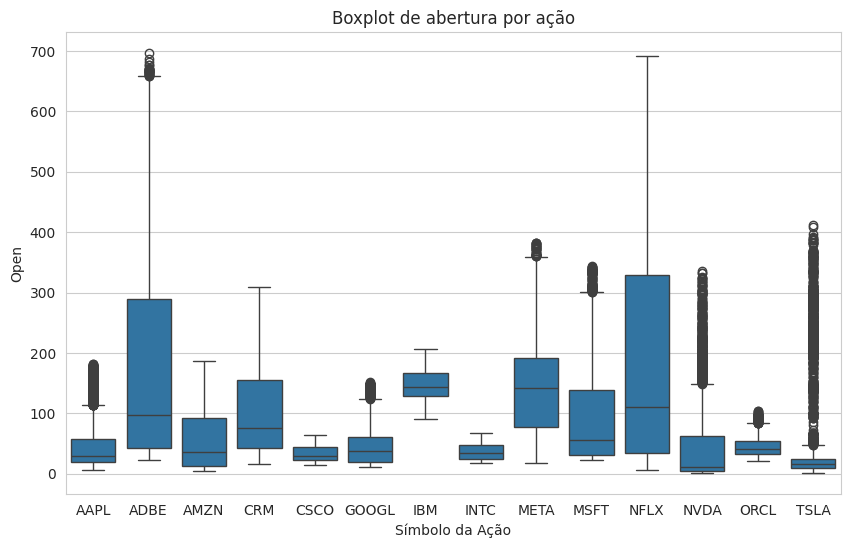

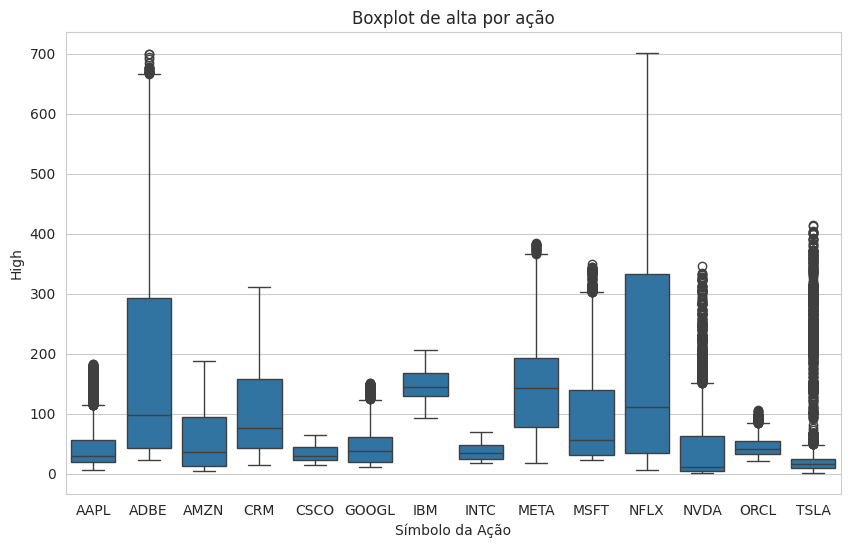

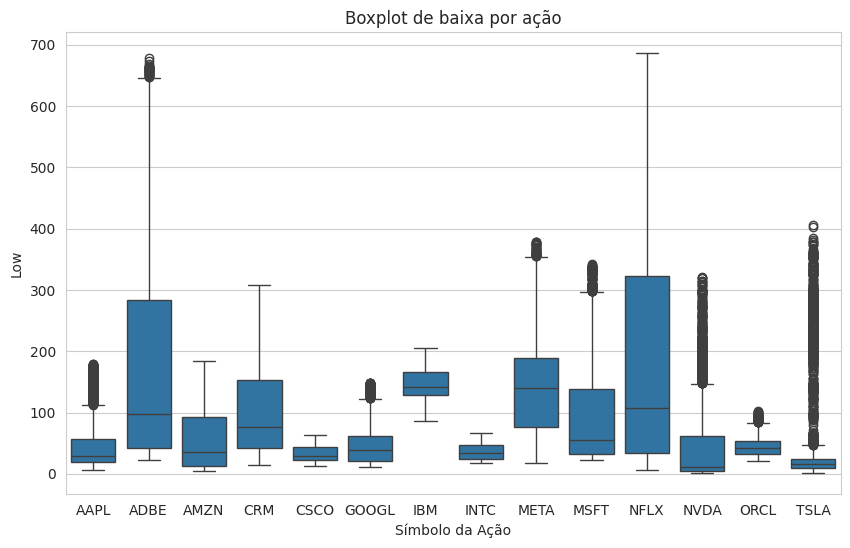

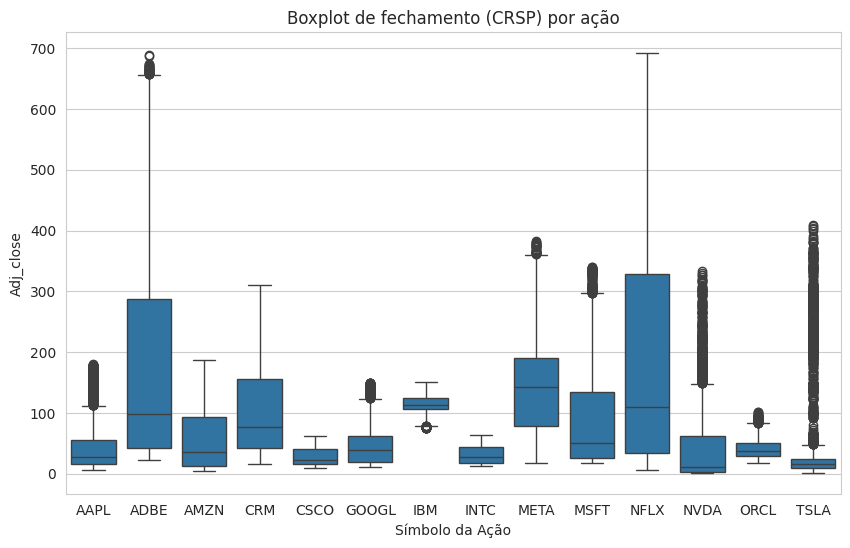

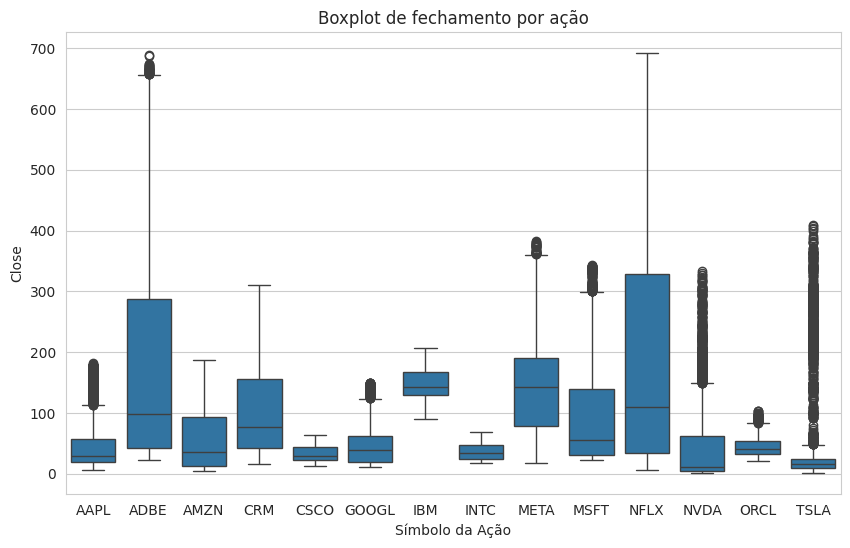

In [ ]:
# Visualizar outliers com boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='volume', data=df_merged)
plt.title('Boxplot de volume por ação')
plt.ylabel('Volume')
plt.xlabel('Símbolo da Ação')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='open', data=df_merged)
plt.title('Boxplot de abertura por ação')
plt.ylabel('Open')
plt.xlabel('Símbolo da Ação')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='high', data=df_merged)
plt.title('Boxplot de alta por ação')
plt.ylabel('High')
plt.xlabel('Símbolo da Ação')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='low', data=df_merged)
plt.title('Boxplot de baixa por ação')
plt.ylabel('Low')
plt.xlabel('Símbolo da Ação')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='adj_close', data=df_merged)
plt.title('Boxplot de fechamento (CRSP) por ação')
plt.ylabel('Adj_close')
plt.xlabel('Símbolo da Ação')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='stock_symbol', y='close', data=df_merged)
plt.title('Boxplot de fechamento por ação')
plt.ylabel('Close')
plt.xlabel('Símbolo da Ação')
plt.show()

In [ ]:
# Selecionar colunas numéricas
numeric_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
outliers_info = {}

for col in numeric_cols:
    Q1 = df_merged[col].quantile(0.25)
    Q3 = df_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # Selecionar outliers com data e código da ação
    outliers = df_merged[(df_merged[col] < lim_inf) | (df_merged[col] > lim_sup)][['date', 'stock_symbol', col]]

    if not outliers.empty:
        outliers_info[col] = outliers

# Exibir resultado
for col, out_df in outliers_info.items():
    print(f"\nOutliers na coluna: {col}")
    print(out_df.sort_values(by='date').head(10))  # Mostra os 10 primeiros por data



Outliers na coluna: open
            date stock_symbol        open
34175 2018-02-22         NFLX  283.880005
34177 2018-02-26         NFLX  288.750000
34178 2018-02-27         NFLX  294.769989
34179 2018-02-28         NFLX  293.100006
34180 2018-03-01         NFLX  292.750000
34181 2018-03-02         NFLX  284.649994
34182 2018-03-05         NFLX  302.850006
34183 2018-03-06         NFLX  319.880005
34184 2018-03-07         NFLX  320.000000
34185 2018-03-08         NFLX  322.200012

Outliers na coluna: high
            date stock_symbol        high
34158 2018-01-29         NFLX  286.809998
34173 2018-02-20         NFLX  285.809998
34174 2018-02-21         NFLX  286.640015
34176 2018-02-23         NFLX  286.000000
34177 2018-02-26         NFLX  295.649994
34178 2018-02-27         NFLX  297.359985
34179 2018-02-28         NFLX  295.750000
34180 2018-03-01         NFLX  295.250000
34181 2018-03-02         NFLX  301.179993
34182 2018-03-05         NFLX  316.910004

Outliers na coluna: low

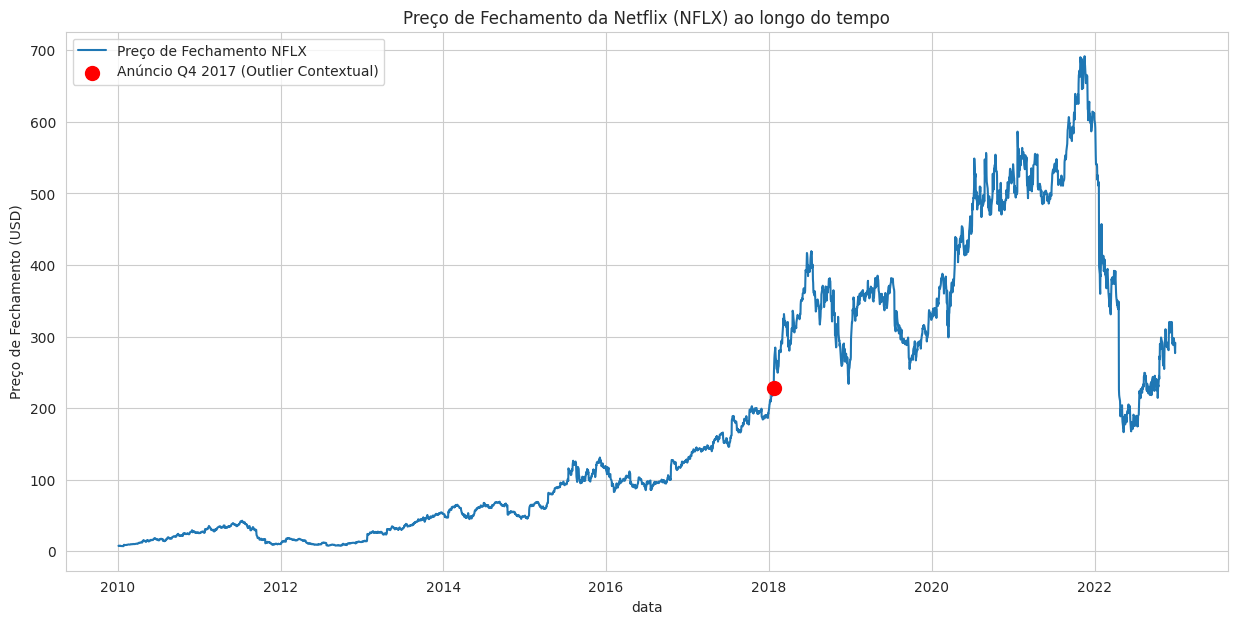

In [ ]:
# Análise contextual para Netflix (NFLX) - Outlier de Preço
netflix_data = df_merged[df_merged['stock_symbol'] == 'NFLX'].set_index('date').sort_index()
if not netflix_data.empty:
    plt.figure(figsize=(15, 7))
    plt.plot(netflix_data['close'], label='Preço de Fechamento NFLX')
    plt.title('Preço de Fechamento da Netflix (NFLX) ao longo do tempo')
    plt.xlabel('data')
    plt.ylabel('Preço de Fechamento (USD)')
    # Destacar o ponto do outlier de 2018-01-22, se presente no dataset
    if '2018-01-22' in netflix_data.index:
        plt.scatter(pd.to_datetime('2018-01-22'), netflix_data.loc['2018-01-22', 'close'], color='red', s=100, zorder=5, label='Anúncio Q4 2017 (Outlier Contextual)')
    plt.legend()
    plt.show()
else:
    print("Dados da Netflix (NFLX) não encontrados para visualização de outlier de preço.")


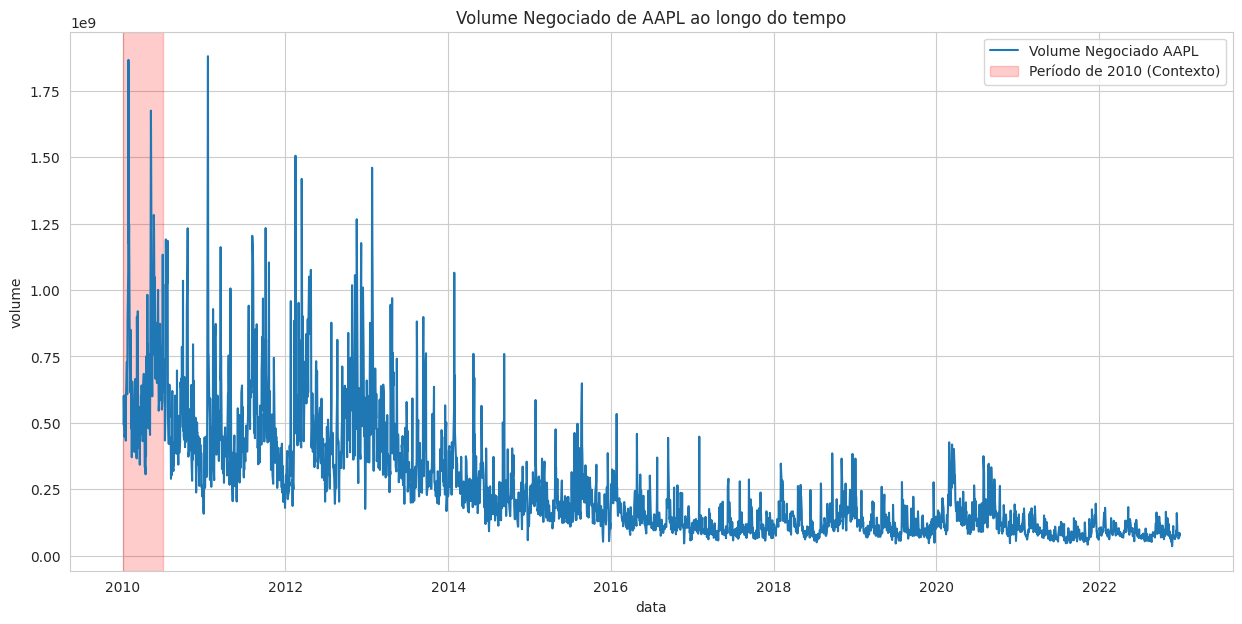

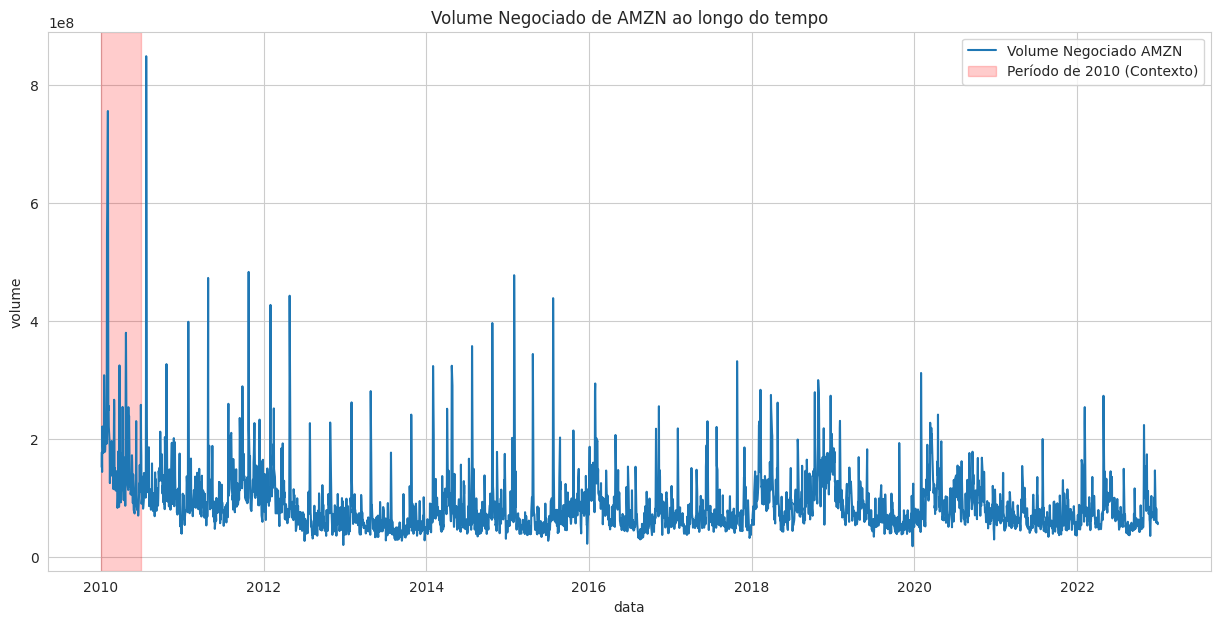

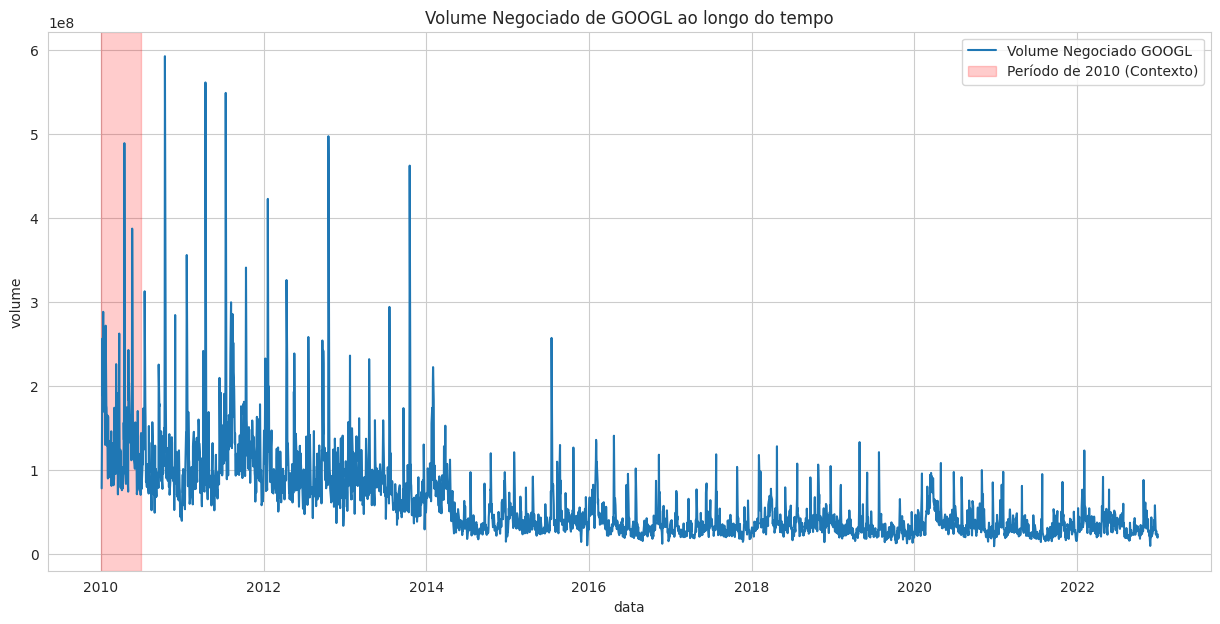

In [ ]:
# Análise contextual para Volume (AAPL, AMZN, GOOGL) - Outlier de Volume
for symbol in ['AAPL', 'AMZN', 'GOOGL']:
    subset_volume = df_merged[df_merged['stock_symbol'] == symbol].set_index('date').sort_index()
    if not subset_volume.empty:
        plt.figure(figsize=(15, 7))
        plt.plot(subset_volume['volume'], label=f'Volume Negociado {symbol}')
        plt.title(f'Volume Negociado de {symbol} ao longo do tempo')
        plt.xlabel('data')
        plt.ylabel('volume')
        # Destacar período de início de 2010
        plt.axvspan(pd.to_datetime('2010-01-01'), pd.to_datetime('2010-06-30'), color='red', alpha=0.2, label='Período de 2010 (Contexto)')
        plt.legend()
        plt.show()
    else:
        print(f"Dados de {symbol} não encontrados para visualização de outlier de volume.")

4. Analise exploratória (EDA)

4.1 Criação de novas variáveis

In [ ]:
df_merged['daily_pct_change'] = df_merged.groupby('stock_symbol')['close'].pct_change() * 100
df_merged['is_bullish'] = (df_merged['close'] > df_merged['open']).astype(int)
df_merged['price_range'] = df_merged['high'] - df_merged['low']


4.2 Medidas de tendência e dispersão

In [ ]:
print("\n--- Visão Geral do Comportamento das Ações: Estatísticas Descritivas ---")

# Estatísticas Descritivas dos Preços de Fechamento por Ação
print("\nEstatísticas Descritivas do Preço de Fechamento ('close') por Ação:")
print(df_merged.groupby('stock_symbol')['close'].describe().to_string())

# Estatísticas Descritivas da Variação Percentual Diária por Ação
print("\nEstatísticas Descritivas da Variação Percentual Diária ('daily_pct_change') por Ação:")
print(df_merged.groupby('stock_symbol')['daily_pct_change'].describe().to_string())

print("\n--- Medidas de Tendência Central Agrupadas por Empresa ---")

# Medidas de tendência central (média, mediana, moda) para 'close' e 'volume'.
# A moda é tratada para casos onde pode haver múltiplos valores ou nenhum.
df_tendencia = df_merged.groupby('stock_symbol').agg(
    media_close=('close', 'mean'),
    mediana_close=('close', 'median'),
    moda_close=('close', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan), # np.nan para moda vazia
    media_volume=('volume', 'mean'),
    mediana_volume=('volume', 'median'),
    moda_volume=('volume', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan) # np.nan para moda vazia
).reset_index()

# Configura o formato de exibição para floats com duas casas decimais e separador de milhares.
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibe o DataFrame com as medidas de tendência central.
print(df_tendencia.to_string(index=False))


--- Visão Geral do Comportamento das Ações: Estatísticas Descritivas ---

Estatísticas Descritivas do Preço de Fechamento ('close') por Ação:
               count        mean         std        min         25%         50%         75%         max
stock_symbol                                                                                           
AAPL          3271.0   51.297154   47.344344   6.858929   18.965536   29.812500   56.761250  182.009995
ADBE          3271.0  186.022299  173.466083  22.690001   42.910000   97.720001  287.955001  688.369995
AMZN          3271.0   58.905287   54.085034   5.430500   13.326250   36.382500   93.138001  186.570496
CRM           3271.0  103.400510   71.213839  15.520000   42.391250   76.260002  155.184998  309.959991
CSCO          3271.0   33.502262   12.646739  13.730000   22.889999   29.540001   44.939999   63.959999
GOOGL         3271.0   49.148954   35.803048  10.912663   20.289915   38.538502   61.692002  149.838501
IBM           3271.0  148

In [ ]:
# Selecionar colunas numéricas principais
variaveis = ['open', 'high', 'low', 'close', 'adj_close', 'volume']

# Calcular medidas de dispersão
for var in variaveis:
    std = df_merged[var].std()
    var_ = df_merged[var].var()
    q1 = df_merged[var].quantile(0.25)
    q3 = df_merged[var].quantile(0.75)
    iqr = q3 - q1

    print(f"\n Variável: {var}")
    print(f"Desvio Padrão: {std:.2f}")
    print(f"Variância: {var_:.2f}")
    print(f"IQR (Q3 - Q1): {iqr:.2f}")


 Variável: open
Desvio Padrão: 101.63
Variância: 10328.04
IQR (Q3 - Q1): 102.99

 Variável: high
Desvio Padrão: 103.00
Variância: 10609.22
IQR (Q3 - Q1): 103.92

 Variável: low
Desvio Padrão: 100.12
Variância: 10024.90
IQR (Q3 - Q1): 101.89

 Variável: close
Desvio Padrão: 101.59
Variância: 10321.12
IQR (Q3 - Q1): 102.98

 Variável: adj_close
Desvio Padrão: 101.00
Variância: 10200.19
IQR (Q3 - Q1): 91.60

 Variável: volume
Desvio Padrão: 93247295.87
Variância: 8695058187601383.00
IQR (Q3 - Q1): 48768250.00


4.3 Comportamento ao longo do tempo

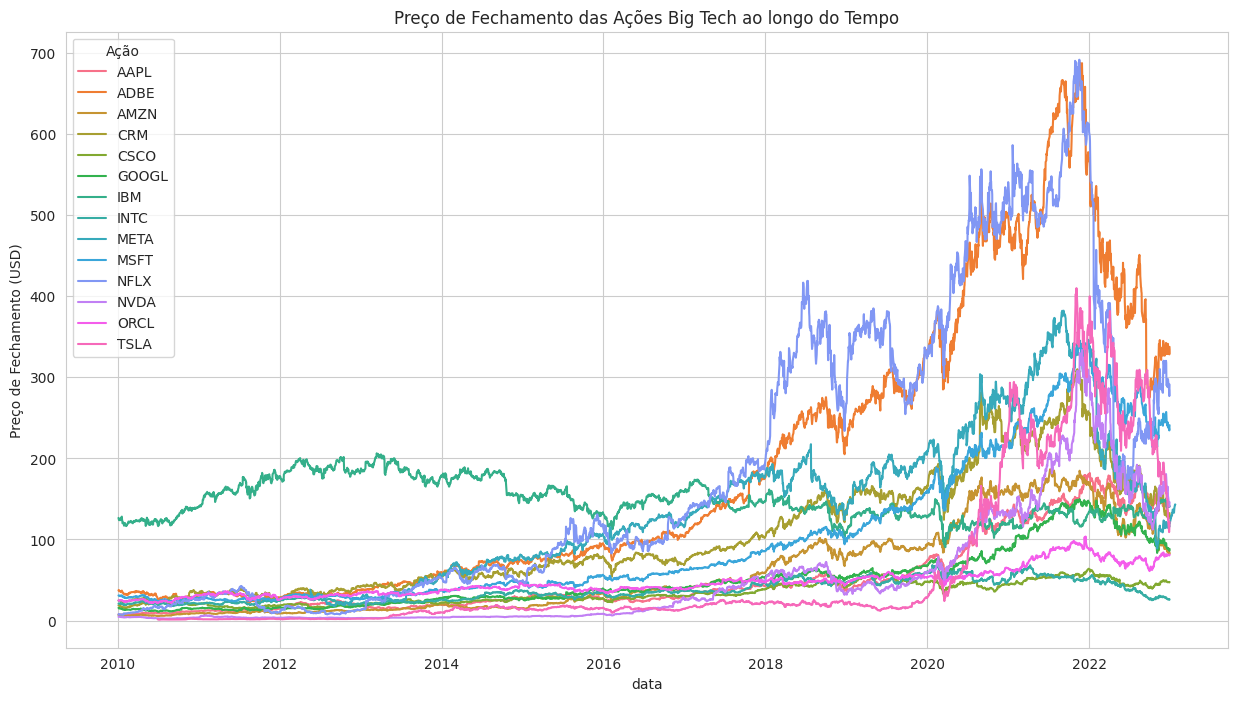

In [ ]:
# Comportamento ao longo do tempo (Preço de Fechamento)
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_merged, x='date', y='close', hue='stock_symbol')
plt.title('Preço de Fechamento das Ações Big Tech ao longo do Tempo')
plt.xlabel('data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend(title='Ação')
plt.show()

4.4 Mapa de calor e correlação

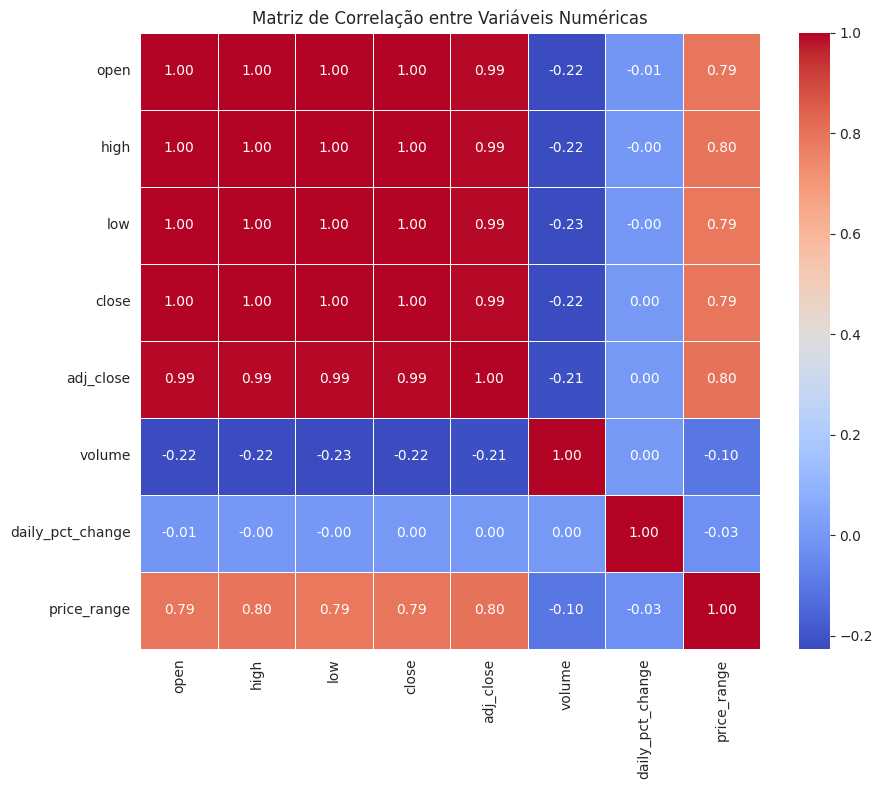

In [ ]:
# Criar e visualizar correlação (mapa de calor)
numeric_cols = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'daily_pct_change', 'price_range']

correlation_matrix = df_merged[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis Numéricas')
plt.show()


4.5 Visão geral

In [ ]:
# Visão geral
summary_table = df_merged.groupby('stock_symbol').agg(
    percent_days_bullish=('is_bullish', lambda x: (x.sum() / len(x) * 100).round(0)),
    avg_daily_pct_change=('daily_pct_change', 'mean'),
    avg_volume_millions=('volume', lambda x: (x.mean() / 1_000_000).round(2))
).reset_index()
print("\n--- Visão geral: ---")
print(summary_table.to_string(index=False))



--- Visão geral: ---
stock_symbol  percent_days_bullish  avg_daily_pct_change  avg_volume_millions
        AAPL                 52.00                  0.10               256.33
        ADBE                 53.00                  0.09                 3.81
        AMZN                 50.00                  0.10                88.34
         CRM                 51.00                  0.09                 6.91
        CSCO                 52.00                  0.03                32.70
       GOOGL                 50.00                  0.07                60.19
         IBM                 51.00                  0.01                 5.04
        INTC                 51.00                  0.02                36.07
        META                 51.00                  0.08                31.18
        MSFT                 52.00                  0.08                38.02
        NFLX                 49.00                  0.17                18.41
        NVDA                 50.00        

4.6 Rentabilidade acumulada

In [ ]:
# Rentabilidade Acumulada
# Garantir que os dados estejam ordenados por data para pegar o primeiro e último preço corretamente
df_sorted_by_date = df_merged.sort_values(by=['stock_symbol', 'date'])
first_prices = df_sorted_by_date.groupby('stock_symbol').first()['close']
last_prices = df_sorted_by_date.groupby('stock_symbol').last()['close']
accumulated_returns = ((last_prices - first_prices) / first_prices * 100).sort_values(ascending=False)
print("\n--- Rentabilidade Acumulada (%): ---")
print(accumulated_returns.round(2))


--- Rentabilidade Acumulada (%): ---
stock_symbol
TSLA    7,568.06
NFLX    3,710.47
NVDA    3,059.11
AAPL    1,595.75
AMZN    1,157.36
ADBE      810.16
MSFT      678.71
CRM       608.58
GOOGL     463.93
META      274.42
ORCL      227.57
CSCO       92.39
INTC       25.53
IBM        11.40
Name: close, dtype: float64


4.7 Desvio padrão e amplitude

In [ ]:
print("\n--- Análise Consolidada de Comportamento e Risco das Ações ---")

# --- Função de Classificação de Risco ---
def classificar_risco(amplitude):
    """
    Classifica o perfil de risco com base na amplitude total de preço.

    Args:
        amplitude (float): A diferença entre o preço máximo e mínimo da ação.

    Returns:
        str: 'Conservador', 'Moderado' ou 'Agressivo'.
    """
    if amplitude < 100:
        return 'Conservador'
    elif amplitude < 300:
        return 'Moderado'
    else:
        return 'Agressivo'


# --- Agregação Única de Todas as Métricas Por Ação ---
df_consolidado = df_merged.groupby('stock_symbol').agg(
    # Métricas de Amplitude e Preço
    preco_min=('close', 'min'),
    preco_max=('close', 'max'),
    amplitude=('close', lambda x: x.max() - x.min()), # Calculando amplitude aqui
    desvio_padrao_close=('close', 'std'), # Desvio padrão do preço de fechamento
    # Métricas de Volatilidade
    std_daily_pct_change=('daily_pct_change', lambda x: np.round(x.std(), 2)),
    avg_price_range=('price_range', 'mean'), # Amplitude média de preço (intraday)
    # Métricas de Volume
    volume_medio=('volume', 'mean')
).reset_index()

# --- Aplica a Classificação de Risco ---
df_consolidado['perfil_risco'] = df_consolidado['amplitude'].apply(classificar_risco)

# --- Organizar e Exibir Resultado ---
# Reordenar colunas para melhor visualização
df_consolidado = df_consolidado[[
    'stock_symbol',
    'preco_min',
    'preco_max',
    'amplitude',
    'perfil_risco',
    'desvio_padrao_close',
    'std_daily_pct_change',
    'avg_price_range',
    'volume_medio'
]]

# Configura o formato de exibição para floats (duas casas decimais, separador de milhares).
# Importante: Esta configuração afeta todas as exibições de DataFrame subsequentes.
pd.set_option('display.float_format', '{:,.2f}'.format)

# Exibe o DataFrame consolidado, ordenado pela amplitude para facilitar a visualização do risco.
print(df_consolidado.sort_values(by='amplitude', ascending=False).to_string(index=False))


--- Análise Consolidada de Comportamento e Risco das Ações ---
stock_symbol  preco_min  preco_max  amplitude perfil_risco  desvio_padrao_close  std_daily_pct_change  avg_price_range   volume_medio
        NFLX       7.02     691.69     684.67    Agressivo               178.88                  3.28             6.01  18,414,854.14
        ADBE      22.69     688.37     665.68    Agressivo               173.47                  2.00             4.59   3,814,336.66
        TSLA       1.05     409.97     408.92    Agressivo                95.54                  3.60             2.77  93,516,465.69
        META      17.73     382.18     364.45    Agressivo                86.76                  2.52             3.75  31,178,146.69
        NVDA       2.22     333.76     331.54    Agressivo                69.48                  2.81             1.96  50,806,126.60
        MSFT      23.01     343.11     320.10    Agressivo                88.23                  1.64             2.03  38,016,469.3

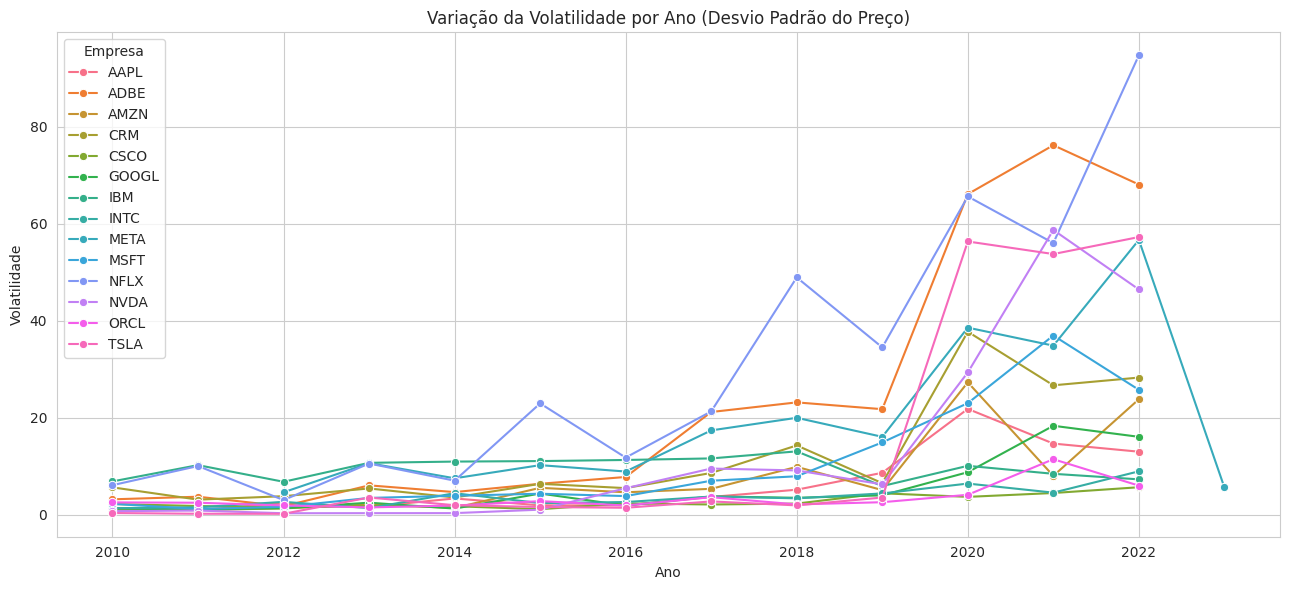

In [ ]:
df_merged['ano'] = df_merged['date'].dt.year
df_merged['mes'] = df_merged['date'].dt.month

vol_ano = df_merged.groupby(['stock_symbol', 'ano'])['close'].std().reset_index()
vol_ano.columns = ['Empresa', 'Ano', 'Desvio_Padrão_Close']

plt.figure(figsize=(13,6))
sns.lineplot(data=vol_ano, x='Ano', y='Desvio_Padrão_Close', hue='Empresa', marker='o')
plt.title('Variação da Volatilidade por Ano (Desvio Padrão do Preço)')
plt.ylabel('Volatilidade')
plt.tight_layout()
plt.show()

4.8 Informações por empresas

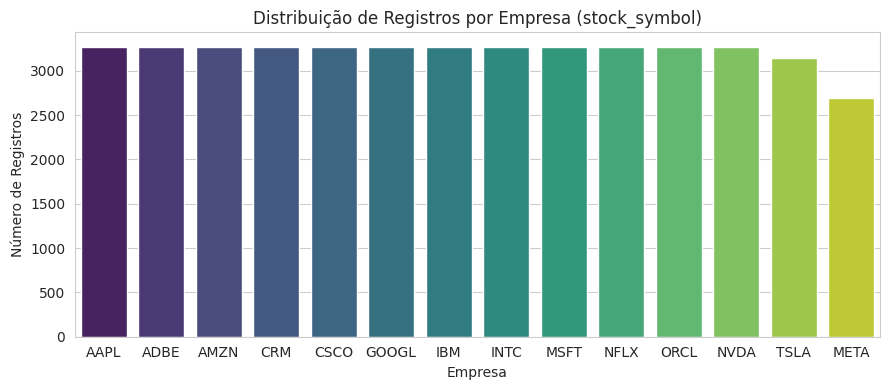

In [ ]:
# Contar registros por empresa
frequencia_empresas = df_merged['stock_symbol'].value_counts().reset_index()
frequencia_empresas.columns = ['stock_symbol', 'frequencia']

# Plotar gráfico de barras
plt.figure(figsize=(9, 4))
sns.barplot(data=frequencia_empresas, x='stock_symbol', y='frequencia', palette='viridis')
plt.title('Distribuição de Registros por Empresa (stock_symbol)')
plt.xlabel('Empresa')
plt.ylabel('Número de Registros')
plt.tight_layout()
plt.show()

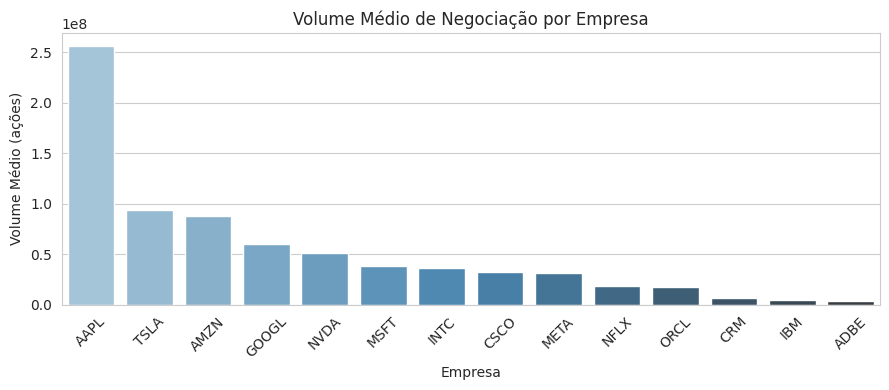

In [ ]:
# Calcular volume médio por empresa
df_volume = df_merged.groupby('stock_symbol')['volume'].mean().reset_index()
df_volume = df_volume.sort_values(by='volume', ascending=False)

# Plotar gráfico de barras
plt.figure(figsize=(9,4))
sns.barplot(data=df_volume, x='stock_symbol', y='volume', palette='Blues_d')
plt.title('Volume Médio de Negociação por Empresa')
plt.ylabel('Volume Médio (ações)')
plt.xlabel('Empresa')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


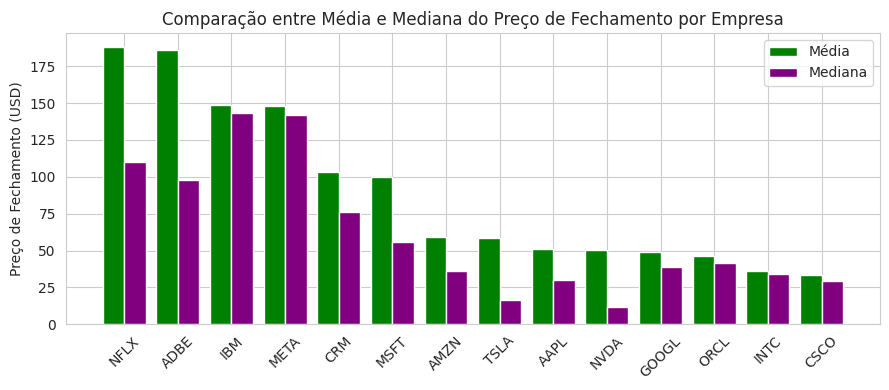

In [ ]:
# Plotar gráfico de barras lado a lado: média vs mediana do preço de fechamento
import numpy as np

df_tendencia_sorted = df_tendencia.sort_values(by='media_close', ascending=False)
x = np.arange(len(df_tendencia_sorted['stock_symbol']))

plt.figure(figsize=(9,4))
plt.bar(x - 0.2, df_tendencia_sorted['media_close'], width=0.4, label='Média', color='green')
plt.bar(x + 0.2, df_tendencia_sorted['mediana_close'], width=0.4, label='Mediana', color='purple')
plt.xticks(x, df_tendencia_sorted['stock_symbol'], rotation=45)
plt.ylabel('Preço de Fechamento (USD)')
plt.title('Comparação entre Média e Mediana do Preço de Fechamento por Empresa')
plt.legend()
plt.tight_layout()
plt.show()



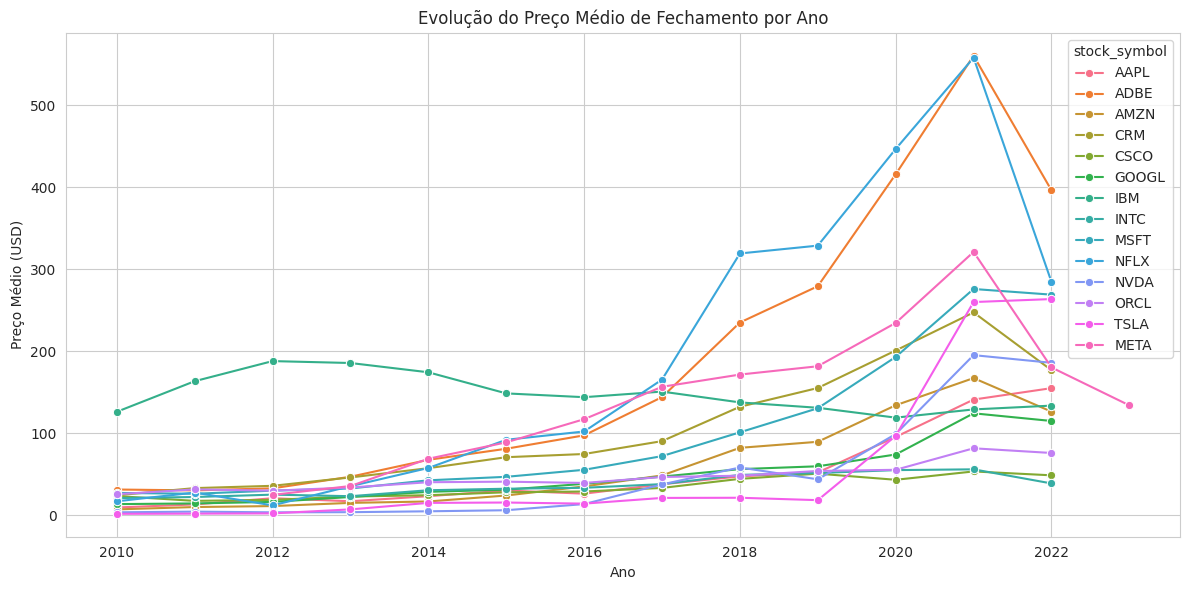

In [ ]:
df_merged['ano'] = df_merged['date'].dt.year
media_ano = df_merged.groupby(['ano', 'stock_symbol'])['close'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=media_ano, x='ano', y='close', hue='stock_symbol', marker='o')
plt.title('Evolução do Preço Médio de Fechamento por Ano')
plt.ylabel('Preço Médio (USD)')
plt.xlabel('Ano')
plt.tight_layout()
plt.show()

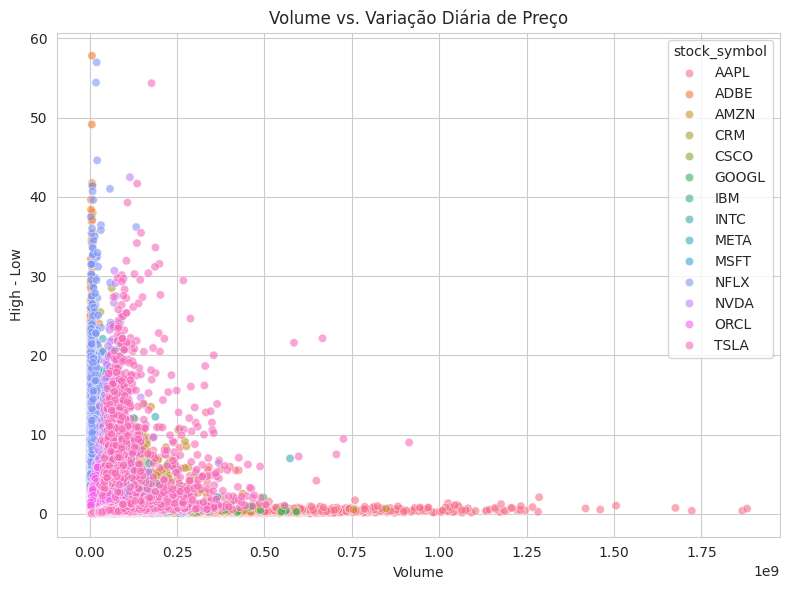

In [ ]:
df_merged['variacao_diaria'] = df_merged['high'] - df_merged['low']

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_merged, x='volume', y='variacao_diaria', hue='stock_symbol', alpha=0.6)
plt.title('Volume vs. Variação Diária de Preço')
plt.xlabel('Volume')
plt.ylabel('High - Low')
plt.tight_layout()
plt.show()

In [ ]:
# Verificar quantidade de valores nulos por coluna
print("Valores nulos por coluna:")
print(df_merged.isnull().sum())

# Verificar se há algum valor nulo no DataFrame
print("\nTem valores nulos no DataFrame?")
print(df_merged.isnull().values.any())

# Verificar número de linhas duplicadas
duplicados = df_merged.duplicated()
print("\n Total de linhas duplicadas:", duplicados.sum())

# (Opcional) Ver duplicatas
if duplicados.sum() > 0:
    print("\nExibindo as duplicatas:")
    print(df_merged[duplicados])

#Se você tem 14 empresas únicas em seu dataset (14 valores distintos na coluna stock_symbol), então cada uma delas contribuirá com um NaN na primeira linha de seu respectivo grupo, totalizando 14 valores nulos para daily_pct_change. Esses NaNs são normais e esperados para este tipo de cálculo e são geralmente tratados em etapas posteriores (por exemplo, removendo-os com dropna() antes de certas análises ou permitindo que funções de agregação os ignorem por padrão).)


Valores nulos por coluna:
stock_symbol         0
date                 0
open                 0
high                 0
low                  0
close                0
adj_close            0
volume               0
company              0
daily_pct_change    14
is_bullish           0
price_range          0
ano                  0
mes                  0
variacao_diaria      0
dtype: int64

Tem valores nulos no DataFrame?
True

 Total de linhas duplicadas: 0


5. Técnicas de analise

5.1 Segmentação


--- Iniciando Técnicas de Análise: Segmentação e Testes de Hipóteses ---


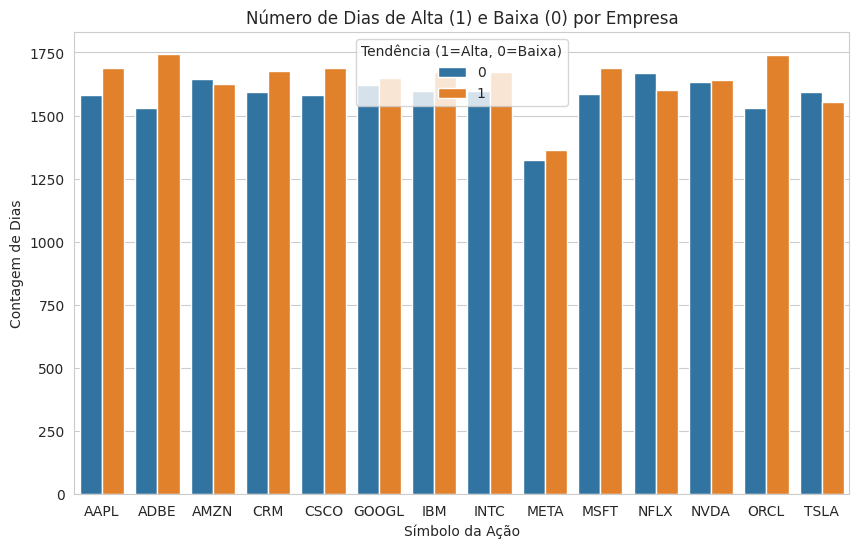

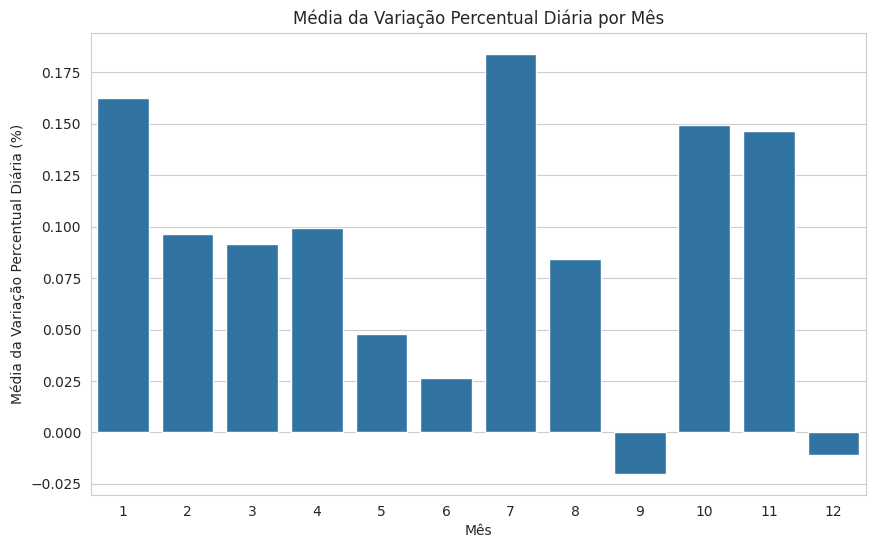

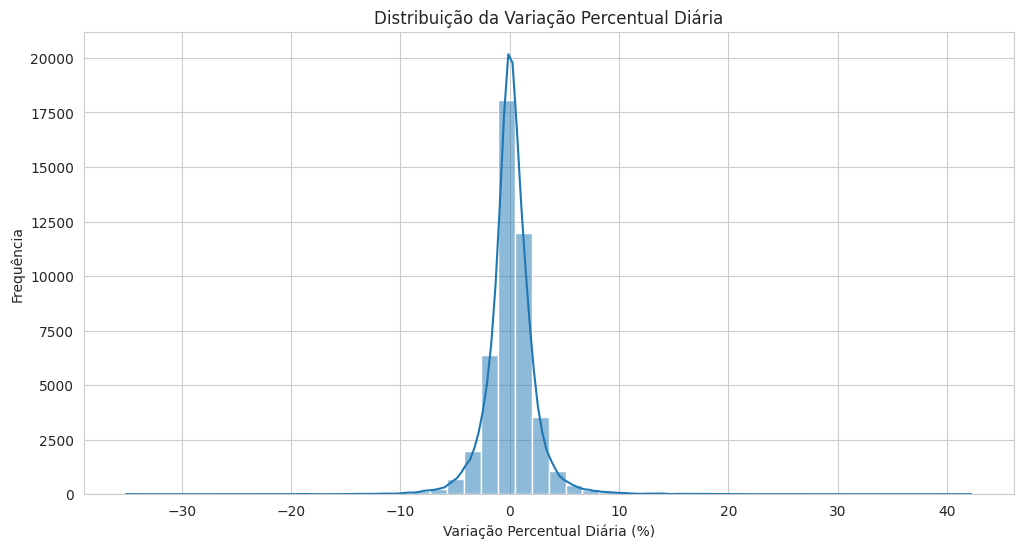

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

df_merged['month'] = df_merged['date'].dt.month

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n--- Iniciando Técnicas de Análise: Segmentação e Testes de Hipóteses ---")

# --- Segmentação ---
# Tendência de alta/baixa por empresa
plt.figure(figsize=(10, 6))
sns.countplot(x='stock_symbol', hue='is_bullish', data=df_merged)
plt.title('Número de Dias de Alta (1) e Baixa (0) por Empresa')
plt.xlabel('Símbolo da Ação')
plt.ylabel('Contagem de Dias')
plt.legend(title='Tendência (1=Alta, 0=Baixa)')
plt.show()

# Média da variação percentual por mês (Sazonalidade)
monthly_avg_pct_change = df_merged.groupby('month')['daily_pct_change'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='daily_pct_change', data=monthly_avg_pct_change)
plt.title('Média da Variação Percentual Diária por Mês')
plt.xlabel('Mês')
plt.ylabel('Média da Variação Percentual Diária (%)')
plt.show()

# Faixa de variação percentual diária (distribuição)
plt.figure(figsize=(12, 6))
sns.histplot(df_merged['daily_pct_change'].dropna(), kde=True, bins=50)
plt.title('Distribuição da Variação Percentual Diária')
plt.xlabel('Variação Percentual Diária (%)')
plt.ylabel('Frequência')
plt.show()

5.2 Hipóteses

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n--- Realizando Testes de Hipóteses e Conclusões ---")

# --- H1: Empresas com maior volume negociado tendem a ter maior variação percentual diária. ---
print("\n--- Hipótese 1: Correlação entre Volume e Variação Percentual Diária ---")
# Natureza: Correlação entre duas variáveis numéricas.
# Teste Escolhido: Correlação de Pearson.
# Porquê: Mede a força e a direção de uma relação linear entre duas variáveis quantitativas.
# P-valor baixo (p < 0.05) indica que a correlação observada é estatisticamente significativa.

df_h1 = df_merged[['volume', 'daily_pct_change']].dropna()
if not df_h1.empty:
    corr_h1, p_value_h1 = stats.pearsonr(df_h1['volume'], df_h1['daily_pct_change'])
    print(f"Correlação de Pearson (Volume vs. Variação % Diária):")
    print(f"  Correlação = {corr_h1:.4f}, Valor-p = {p_value_h1:.4f}")
    print("  Conclusão: Um valor-p baixo indicaria que a correlação não é devido ao acaso.")
else:
    print("  Dados insuficientes para testar Hipótese 1 após remover NaNs.")


# --- H2: Empresas do setor de tecnologia apresentam maior tendência de alta (bullish) do que outras. ---
print("\n--- Hipótese 2: Associação entre Empresa e Tendência Bullish ---")
# Natureza: Associação entre duas variáveis categóricas (stock_symbol e is_bullish).
# Teste Escolhido: Teste Qui-quadrado de Independência (Chi-squared test).
# Porquê: Avalia se há uma associação estatisticamente significativa entre duas variáveis categóricas.
# P-valor baixo (p < 0.05) indica que a associação observada é estatisticamente significativa,
# sugerindo que a tendência bullish pode depender da empresa.

contingency_table_h2 = pd.crosstab(df_merged['stock_symbol'], df_merged['is_bullish'])
if not contingency_table_h2.empty and contingency_table_h2.shape[0] > 1 and contingency_table_h2.shape[1] > 1:
    chi2_h2, p_value_h2, _, _ = stats.chi2_contingency(contingency_table_h2)
    print(f"Teste Qui-quadrado (Tendência Bullish por Empresa):")
    print(f"  Qui-quadrado = {chi2_h2:.2f}, Valor-p = {p_value_h2:.4f}")
    print("  Conclusão: Um valor-p baixo sugere que a tendência de alta não é independente da empresa.")
else:
    print("  Dados insuficientes ou estrutura inadequada para testar Hipótese 2 (Qui-quadrado).")


# --- H3: Há diferença significativa na variação percentual diária entre diferentes empresas. ---
print("\n--- Hipótese 3: Diferença na Variação Percentual Diária entre Empresas ---")
# Natureza: Comparação das médias de uma variável numérica (daily_pct_change) entre mais de dois grupos (stock_symbol).
# Teste Escolhido: Análise de Variância (ANOVA).
# Porquê: Compara as médias de três ou mais grupos para ver se há alguma diferença estatisticamente significativa.
# P-valor baixo (p < 0.05) indica que há pelo menos um par de empresas com médias de variação diária significativamente diferentes.

data_anova_h3 = [df_merged[df_merged['stock_symbol'] == s]['daily_pct_change'].dropna() for s in df_merged['stock_symbol'].unique()]
data_anova_h3 = [arr for arr in data_anova_h3 if not arr.empty] # Remover arrays vazios
if len(data_anova_h3) > 1: # Precisa de pelo menos 2 grupos para ANOVA
    f_stat_h3, p_value_h3 = stats.f_oneway(*data_anova_h3)
    print(f"Teste ANOVA (Variação % Diária entre Empresas):")
    print(f"  Estatística F = {f_stat_h3:.2f}, Valor-p = {p_value_h3:.4f}")
    print("  Conclusão: Um valor-p baixo sugere que as médias de variação diária diferem significativamente entre as empresas.")
else:
    print("  Dados insuficientes para testar Hipótese 3 (ANOVA - menos de 2 grupos com dados).")


# --- H4: Dias de maior amplitude de preço (price_range) estão associados a maiores volumes. ---
print("\n--- Hipótese 4: Correlação entre Amplitude de Preço e Volume ---")
# Natureza: Correlação entre duas variáveis numéricas.
# Teste Escolhido: Correlação de Pearson.
# Porquê: Similar à H1, avalia a relação linear entre duas variáveis quantitativas.

df_h4 = df_merged[['price_range', 'volume']].dropna()
if not df_h4.empty:
    corr_h4, p_value_h4 = stats.pearsonr(df_h4['price_range'], df_h4['volume'])
    print(f"Correlação de Pearson (Amplitude de Preço vs. Volume):")
    print(f"  Correlação = {corr_h4:.4f}, Valor-p = {p_value_h4:.4f}")
    print("  Conclusão: Um valor-p baixo indicaria que a correlação não é devido ao acaso.")
else:
    print("  Dados insuficientes para testar Hipótese 4 após remover NaNs.")


# --- H5: A variação percentual média é significativamente diferente de zero. ---
print("\n--- Hipótese 5: Variação Percentual Média é Diferente de Zero ---")
# Natureza: Comparação da média de uma amostra com um valor conhecido (zero).
# Teste Escolhido: Teste t de uma amostra (One-sample t-test).
# Porquê: Determina se a média de uma única amostra é estatisticamente diferente de um valor hipotético (popmean).
# P-valor baixo (p < 0.05) indicaria que a média não é zero por acaso.

df_h5 = df_merged['daily_pct_change'].dropna()
if not df_h5.empty:
    t_stat_h5, p_value_h5 = stats.ttest_1samp(df_h5, popmean=0)
    print(f"Teste t de uma amostra (Variação % Média vs. Zero):")
    print(f"  Estatística t = {t_stat_h5:.2f}, Valor-p = {p_value_h5:.4f}")
    print("  Conclusão: Um valor-p baixo indica que a média da variação percentual é estatisticamente diferente de zero.")
else:
    print("  Dados insuficientes para testar Hipótese 5 após remover NaNs.")


# --- H6: A variação percentual é maior em meses específicos. ---
print("\n--- Hipótese 6: Variação Percentual Diária difere entre Meses ---")
# Natureza: Comparação das médias de uma variável numérica (daily_pct_change) entre mais de dois grupos (meses).
# Teste Escolhido: Análise de Variância (ANOVA).
# Porquê: Similar à H3, compara as médias de três ou mais grupos (meses) para ver se há alguma diferença estatisticamente significativa.
# P-valor baixo (p < 0.05) indicaria sazonalidade na variação.

df_h6 = df_merged[['month', 'daily_pct_change']].dropna()
data_anova_h6 = [df_h6[df_h6['month'] == m]['daily_pct_change'] for m in sorted(df_h6['month'].unique())]
data_anova_h6 = [arr for arr in data_anova_h6 if not arr.empty] # Remover arrays vazios
if len(data_anova_h6) > 1: # Precisa de pelo menos 2 grupos para ANOVA
    f_stat_h6, p_value_h6 = stats.f_oneway(*data_anova_h6)
    print(f"Teste ANOVA (Variação % Diária entre Meses):")
    print(f"  Estatística F = {f_stat_h6:.2f}, Valor-p = {p_value_h6:.4f}")
    print("  Conclusão: Um valor-p baixo sugere que a variação percentual difere significativamente entre os meses.")
else:
    print("  Dados insuficientes para testar Hipótese 6 (ANOVA - menos de 2 grupos com dados).")

print("\n--- Todos os Testes de Hipóteses Executados ---")


--- Realizando Testes de Hipóteses e Conclusões ---

--- Hipótese 1: Correlação entre Volume e Variação Percentual Diária ---
Correlação de Pearson (Volume vs. Variação % Diária):
  Correlação = 0.0022, Valor-p = 0.6389
  Conclusão: Um valor-p baixo indicaria que a correlação não é devido ao acaso.

--- Hipótese 2: Associação entre Empresa e Tendência Bullish ---
Teste Qui-quadrado (Tendência Bullish por Empresa):
  Qui-quadrado = 27.40, Valor-p = 0.0110
  Conclusão: Um valor-p baixo sugere que a tendência de alta não é independente da empresa.

--- Hipótese 3: Diferença na Variação Percentual Diária entre Empresas ---
Teste ANOVA (Variação % Diária entre Empresas):
  Estatística F = 1.82, Valor-p = 0.0343
  Conclusão: Um valor-p baixo sugere que as médias de variação diária diferem significativamente entre as empresas.

--- Hipótese 4: Correlação entre Amplitude de Preço e Volume ---
Correlação de Pearson (Amplitude de Preço vs. Volume):
  Correlação = -0.1017, Valor-p = 0.0000
  Con

5.3 Regressão Linear

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

print("\n--- Iniciando Modelagem Preditiva: Regressão Linear (Previsão do dia Seguinte) ---")

# Criar uma cópia para evitar modificar o df_merged original para esta análise específica
df_model_linear = df_merged.copy()

# Ordenar por símbolo da ação e data para garantir que o .shift() funcione corretamente
df_model_linear = df_model_linear.sort_values(by=['stock_symbol', 'date'])

# Criar variáveis preditoras com base nos dados do dia ANTERIOR (.shift(1))
df_model_linear['prev_open'] = df_model_linear.groupby('stock_symbol')['open'].shift(1)
df_model_linear['prev_high'] = df_model_linear.groupby('stock_symbol')['high'].shift(1)
df_model_linear['prev_low'] = df_model_linear.groupby('stock_symbol')['low'].shift(1)
df_model_linear['prev_volume'] = df_model_linear.groupby('stock_symbol')['volume'].shift(1)

# A variável target 'close' é o preço de fechamento do dia atual
y_linear = df_model_linear['close']

# As features são os valores do dia anterior
X_linear = df_model_linear[['prev_open', 'prev_high', 'prev_low', 'prev_volume']]

# Remover linhas que contêm NaNs (resultado do .shift(1) e quaisquer outros NaNs)
# Fazemos isso APÓS definir X e y para garantir que as linhas removidas sejam as mesmas
df_model_linear_final = pd.concat([X_linear, y_linear], axis=1).dropna()

X_linear_final = df_model_linear_final[['prev_open', 'prev_high', 'prev_low', 'prev_volume']]
y_linear_final = df_model_linear_final['close']


# Verificar se há dados suficientes após o dropna
if X_linear_final.empty or y_linear_final.empty:
    print("Erro: Dados insuficientes para treinamento após ajuste das features (possivelmente muitas linhas removidas por NaN).")
else:
    X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear_final, y_linear_final, test_size=0.2, random_state=42)

    model_linear = LinearRegression()
    model_linear.fit(X_train_linear, y_train_linear)

    y_pred_linear = model_linear.predict(X_test_linear)

    mse_linear = mean_squared_error(y_test_linear, y_pred_linear)
    r2_linear = r2_score(y_test_linear, y_pred_linear)

    print(f"\n--- Resultados da Regressão Linear para Previsão de Preço de Fechamento (Dia Seguinte): ---")
    print(f"R² (Coeficiente de Determinação): {r2_linear:.6f}")
    print(f"MSE (Erro Quadrático Médio): {mse_linear:.3f}")
    print("Conclusão: Ajustamos o modelo para prever o preço de fechamento com base nos dados do dia anterior. O R² ainda é alto (embora provavelmente menor que 0.999), indicando que os preços de mercado tendem a ter alta correlação de um dia para o outro. Este modelo agora tenta uma previsão mais realista do 'close' do dia seguinte com base em informações passadas.")
    print("\nLembre-se que o R² para previsão de séries temporais pode ser alto mesmo sem 'overfitting' se a série for muito estável. Para modelos financeiros, outras métricas e validações (como validação walk-forward) podem ser mais indicadas.")


--- Iniciando Modelagem Preditiva: Regressão Linear (Previsão do dia Seguinte) ---

--- Resultados da Regressão Linear para Previsão de Preço de Fechamento (Dia Seguinte): ---
R² (Coeficiente de Determinação): 0.998661
MSE (Erro Quadrático Médio): 14.394
Conclusão: Ajustamos o modelo para prever o preço de fechamento com base nos dados do dia anterior. O R² ainda é alto (embora provavelmente menor que 0.999), indicando que os preços de mercado tendem a ter alta correlação de um dia para o outro. Este modelo agora tenta uma previsão mais realista do 'close' do dia seguinte com base em informações passadas.

Lembre-se que o R² para previsão de séries temporais pode ser alto mesmo sem 'overfitting' se a série for muito estável. Para modelos financeiros, outras métricas e validações (como validação walk-forward) podem ser mais indicadas.


5.4 Risco Relativo


--- Iniciando Análise de Risco Relativo do Zero ---

1. Calculando Métricas Absolutas por Ação (amplitude, desvio padrão, etc.):
  stock_symbol  preco_min  preco_max  amplitude_absoluta  desvio_padrao_close  \
0         AAPL       6.86     182.01              175.15                47.34   
1         ADBE      22.69     688.37              665.68               173.47   
2         AMZN       5.43     186.57              181.14                54.09   
3          CRM      15.52     309.96              294.44                71.21   
4         CSCO      13.73      63.96               50.23                12.65   

   avg_price_range_intraday  
0                      1.14  
1                      4.59  
2                      1.43  
3                      2.72  
4                      0.62  

2. Média da Amplitude Absoluta de todas as ações (Benchmark): $276.00

3. Calculando Amplitude Relativa (Amplitude da Ação / Benchmark):
  stock_symbol  amplitude_absoluta  amplitude_relativa
0         

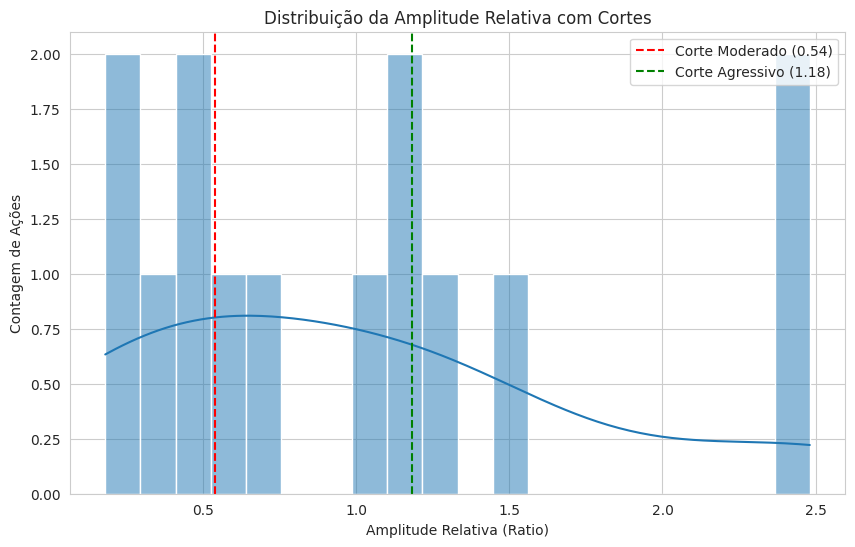


5. Classificando Ações pelo Perfil de Risco Relativo:
  stock_symbol  amplitude_absoluta  amplitude_relativa  \
0         AAPL              175.15                0.63   
1         ADBE              665.68                2.41   
2         AMZN              181.14                0.66   
3          CRM              294.44                1.07   
4         CSCO               50.23                0.18   

  perfil_risco_relativo_quantil  
0                      Moderado  
1                     Agressivo  
2                      Moderado  
3                      Moderado  
4                   Conservador  

--- Resultados Finais do Perfil de Risco Relativo por Ação (Ordenado por Amplitude Relativa) ---
stock_symbol  amplitude_absoluta  amplitude_relativa perfil_risco_relativo_quantil  desvio_padrao_close  avg_price_range_intraday
        NFLX              684.67                2.48                     Agressivo               178.88                      6.01
        ADBE              665.68  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações de exibição para facilitar a visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format) # Formato para floats
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n--- Iniciando Análise de Risco Relativo do Zero ---")

# --- PASSO 1: Garantir que df_merged está pronto e calcular Amplitude Absoluta ---

print("\n1. Calculando Métricas Absolutas por Ação (amplitude, desvio padrão, etc.):")
df_consolidado_risco = df_merged.groupby('stock_symbol').agg(
    preco_min=('close', 'min'),
    preco_max=('close', 'max'),
    amplitude_absoluta=('close', lambda x: x.max() - x.min()), # Amplitude absoluta
    desvio_padrao_close=('close', 'std'),
    # Calculando também a amplitude média diária para referência futura
    avg_price_range_intraday=('price_range', 'mean') # price_range é (high-low) do dia
).reset_index()

print(df_consolidado_risco.head())

# --- PASSO 2: Calcular a Média da Amplitude do Mercado (Benchmark) ---
media_amplitude_mercado = df_consolidado_risco['amplitude_absoluta'].mean()
print(f"\n2. Média da Amplitude Absoluta de todas as ações (Benchmark): ${media_amplitude_mercado:,.2f}")

# --- PASSO 3: Calcular a Amplitude Relativa para Cada Ação ---
# (Evitar divisão por zero se o benchmark for 0, o que é improvável aqui)
df_consolidado_risco['amplitude_relativa'] = df_consolidado_risco['amplitude_absoluta'] / media_amplitude_mercado
print("\n3. Calculando Amplitude Relativa (Amplitude da Ação / Benchmark):")
print(df_consolidado_risco[['stock_symbol', 'amplitude_absoluta', 'amplitude_relativa']].head())

# --- PASSO 4: Determinar os "Melhores Cortes" para Classificação (usando Quantis) ---
# Vamos usar os quantis para dividir a distribuição da amplitude relativa em 3 partes:
# Terço inferior: Conservador
# Terço médio: Moderado
# Terço superior: Agressivo

# Calcular os pontos de corte
corte_moderado = df_consolidado_risco['amplitude_relativa'].quantile(0.33) # Limite superior para Conservador
corte_agressivo = df_consolidado_risco['amplitude_relativa'].quantile(0.66) # Limite superior para Moderado

print(f"\n4. Determinando Cortes para Risco Relativo (usando Quantis):")
print(f"   Corte para 'Conservador' (amplitude_relativa <= {corte_moderado:.2f})")
print(f"   Corte para 'Moderado' (amplitude_relativa > {corte_moderado:.2f} e <= {corte_agressivo:.2f})")
print(f"   Corte para 'Agressivo' (amplitude_relativa > {corte_agressivo:.2f})")

# Opcional: Visualizar a distribuição para entender os cortes
plt.figure(figsize=(10, 6))
sns.histplot(df_consolidado_risco['amplitude_relativa'], bins=20, kde=True)
plt.axvline(corte_moderado, color='red', linestyle='--', label=f'Corte Moderado ({corte_moderado:.2f})')
plt.axvline(corte_agressivo, color='green', linestyle='--', label=f'Corte Agressivo ({corte_agressivo:.2f})')
plt.title('Distribuição da Amplitude Relativa com Cortes')
plt.xlabel('Amplitude Relativa (Ratio)')
plt.ylabel('Contagem de Ações')
plt.legend()
plt.show()

# --- PASSO 5: Classificar as Ações com base no Risco Relativo ---
def classificar_risco_relativo_final(ratio):
    if ratio <= corte_moderado:
        return 'Conservador'
    elif ratio <= corte_agressivo:
        return 'Moderado'
    else:
        return 'Agressivo'

df_consolidado_risco['perfil_risco_relativo_quantil'] = df_consolidado_risco['amplitude_relativa'].apply(classificar_risco_relativo_final)
print("\n5. Classificando Ações pelo Perfil de Risco Relativo:")
print(df_consolidado_risco[['stock_symbol', 'amplitude_absoluta', 'amplitude_relativa', 'perfil_risco_relativo_quantil']].head())

# --- PASSO 6: Exibir os Resultados Finais ---
print("\n--- Resultados Finais do Perfil de Risco Relativo por Ação (Ordenado por Amplitude Relativa) ---")
df_final_risco_relativo = df_consolidado_risco[[
    'stock_symbol',
    'amplitude_absoluta',
    'amplitude_relativa',
    'perfil_risco_relativo_quantil',
    'desvio_padrao_close',
    'avg_price_range_intraday'
]].sort_values(by='amplitude_relativa', ascending=False)

print(df_final_risco_relativo.to_string(index=False))

print("\n--- Análise de Risco Relativo Concluída ---")

6. Criação de nova tabela final

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações de exibição e warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("--- Iniciando a criação da tabela final com informações consolidadas por empresa ---")

# --- PASSO 0: Carregar e Preparar df_merged do zero (garantir que temos os dados base) ---
print("\n0. Carregando dados e preparando df_merged...")
try:
    df_companies = pd.read_csv('companies.csv')
    df_stock_prices = pd.read_excel('stock_prices.xlsx')

    df_merged = pd.merge(df_stock_prices, df_companies, on='stock_symbol', how='left')

    df_merged.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low',
        'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
    }, inplace=True)

    df_merged['Date'] = pd.to_datetime(df_merged['date'], errors='coerce')
    df_merged.dropna(subset=['Date', 'close', 'open', 'high', 'low', 'volume'], inplace=True)
    df_merged.drop_duplicates(inplace=True)

    df_merged['daily_pct_change'] = df_merged.groupby('stock_symbol')['close'].pct_change() * 100
    df_merged['price_range'] = df_merged['high'] - df_merged['low']
    df_merged['month'] = df_merged['Date'].dt.month
    df_merged['is_bullish'] = (df_merged['close'] > df_merged['open']).astype(int)

    print("  df_merged preparado com sucesso.")

except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado. Certifique-se de que 'companies.csv' e 'stock_prices.xlsx' estão no diretório correto. Detalhes: {e}")
    raise
except Exception as e:
    print(f"Erro na preparação de df_merged: {e}.")
    raise

# --- PASSO 1: CALCULAR AS MÉTRICAS CONSOLIDADAS ABSOLUTAS ---
print("\n1. Calculando métricas consolidadas absolutas por ação (df_consolidado_abs)...")

def classificar_risco_absoluto(amplitude):
    if amplitude < 100:
        return 'Conservador'
    elif amplitude < 300:
        return 'Moderado'
    else:
        return 'Agressivo'

df_consolidado_abs = df_merged.groupby('stock_symbol').agg(
    preco_min=('close', 'min'),
    preco_max=('close', 'max'),
    amplitude_historica=('close', lambda x: x.max() - x.min()),
    desvio_padrao_close=('close', 'std'),
    std_daily_pct_change=('daily_pct_change', lambda x: np.round(x.std(), 2)),
    avg_price_range_intraday=('price_range', 'mean'),
    volume_medio=('volume', 'mean')
).reset_index()

df_consolidado_abs['perfil_risco_absoluto'] = df_consolidado_abs['amplitude_historica'].apply(classificar_risco_absoluto)


# --- PASSO 2: CALCULAR O RISCO RELATIVO ---
print("\n2. Calculando risco relativo por ação e adicionando ao df_consolidado_abs...")

media_amplitude_mercado = df_consolidado_abs['amplitude_historica'].mean()
if media_amplitude_mercado == 0:
    df_consolidado_abs['amplitude_relativa'] = 0
else:
    df_consolidado_abs['amplitude_relativa'] = df_consolidado_abs['amplitude_historica'] / media_amplitude_mercado

amplitude_relativa_filtered = df_consolidado_abs['amplitude_relativa'].dropna()
if not amplitude_relativa_filtered.empty:
    corte_moderado = amplitude_relativa_filtered.quantile(0.33)
    corte_agressivo = amplitude_relativa_filtered.quantile(0.66)
else:
    corte_moderado = 0
    corte_agressivo = 0

def classificar_risco_relativo_final(ratio):
    if ratio <= corte_moderado:
        return 'Conservador'
    elif ratio <= corte_agressivo:
        return 'Moderado'
    else:
        return 'Agressivo'

df_consolidado_abs['perfil_risco_relativo'] = df_consolidado_abs['amplitude_relativa'].apply(classificar_risco_relativo_final)


# --- PASSO 3: Realizar a JUNÇÃO (MERGE) no df_merged ---
print("\n3. Realizando o merge das informações consolidadas no df_merged...")

# Selecionar as colunas de df_consolidado_abs que queremos adicionar ao df_merged
colunas_para_merge = [
    'stock_symbol',
    'preco_min',
    'preco_max',
    'amplitude_historica',
    'perfil_risco_absoluto',
    'amplitude_relativa',
    'perfil_risco_relativo',
    'desvio_padrao_close',
    'std_daily_pct_change',
    'avg_price_range_intraday',
    'volume_medio'
]

df_resumo_para_merge = df_consolidado_abs[colunas_para_merge]

# Executar o merge. 'how='left'' garante que todas as linhas de df_merged sejam mantidas.
df_merged_final = pd.merge(df_merged, df_resumo_para_merge, on='stock_symbol', how='left')

print("\n--- Tabela Final: df_merged_final com informações consolidadas ---")
print("Exemplo das primeiras 10 linhas do df_merged_final com as novas colunas:")
# Exibir algumas colunas para demonstrar o resultado
print(df_merged_final[[
    'Date',
    'stock_symbol',
    'close',
    'perfil_risco_absoluto',
    'perfil_risco_relativo',
    'amplitude_historica',
    'desvio_padrao_close',
    'volume_medio'
]].head(10))

print(f"\nNúmero total de linhas no df_merged_final: {len(df_merged_final)}")
print(f"Número de valores nulos em 'perfil_risco_relativo' após o merge: {df_merged_final['perfil_risco_relativo'].isnull().sum()}")

print("\n--- Processo de Merge Concluído com Sucesso ---")
print("O DataFrame 'df_merged_final' agora contém todas as informações diárias e as métricas consolidadas por empresa.")

--- Iniciando a criação da tabela final com informações consolidadas por empresa ---

0. Carregando dados e preparando df_merged...
  df_merged preparado com sucesso.

1. Calculando métricas consolidadas absolutas por ação (df_consolidado_abs)...

2. Calculando risco relativo por ação e adicionando ao df_consolidado_abs...

3. Realizando o merge das informações consolidadas no df_merged...

--- Tabela Final: df_merged_final com informações consolidadas ---
Exemplo das primeiras 10 linhas do df_merged_final com as novas colunas:
        Date stock_symbol  close perfil_risco_absoluto perfil_risco_relativo  \
0 2010-01-04         AAPL   7.64              Moderado              Moderado   
1 2010-01-05         AAPL   7.66              Moderado              Moderado   
2 2010-01-06         AAPL   7.53              Moderado              Moderado   
3 2010-01-07         AAPL   7.52              Moderado              Moderado   
4 2010-01-08         AAPL   7.57              Moderado            

In [ ]:
print("\n--- Salvando df_merged_final em arquivo CSV ---")

# Nome do arquivo que será criado
nome_arquivo_csv = 'df_merged_final.csv'

# Salvar o DataFrame em CSV
# index=False é importante para não salvar o índice do DataFrame como uma coluna no CSV
try:
    df_merged_final.to_csv(nome_arquivo_csv, index=False)
    print(f"DataFrame 'df_merged_final' salvo com sucesso como '{nome_arquivo_csv}'")
    print("Você pode encontrar o arquivo na mesma pasta onde seu notebook está sendo executado.")
except Exception as e:
    print(f"Erro ao salvar o DataFrame: {e}")

# Se você preferir salvar como Excel:
# nome_arquivo_excel = 'df_merged_final.xlsx'
# try:
#     df_merged_final.to_excel(nome_arquivo_excel, index=False)
#     print(f"\nDataFrame 'df_merged_final' salvo com sucesso como '{nome_arquivo_excel}'")
# except Exception as e:
#     print(f"Erro ao salvar o DataFrame como Excel: {e}")


--- Salvando df_merged_final em arquivo CSV ---
DataFrame 'df_merged_final' salvo com sucesso como 'df_merged_final.csv'
Você pode encontrar o arquivo na mesma pasta onde seu notebook está sendo executado.
